In [33]:
import netket as nk
import json
import numpy as np
from pickle import dump
import matplotlib.pyplot as plt
from functools import reduce
from scipy.stats import norm
import jax
import pickle

# import new functions for excited state
import expect_grad_ex
import vmc_ex




In [35]:
def CSHam(N, B, Ak):
    # Make graph with of length N with no periodic boundary conditions
    g = nk.graph.Hypercube(length=N, n_dim=1, pbc=False)
    # Spin based Hilbert Space
    hilbertSpace = nk.hilbert.Spin(s=0.5, N=g.n_nodes)
    # Define spin operators with \hbar set to 1
    sz = 0.5 * np.array([[1, 0], [0, -1]])
    sx = 0.5 * np.array([[0, 1], [1, 0]])
    sy = 0.5 * np.array([[0, -1j], [1j, 0]])
    operators = []
    sites = []
    # Central spin term
    operators.append((B * sz).tolist()) #array to list(ordered and changeable)
    sites.append([0])
    # Interaction term
    itOp = np.kron(sz, sz) + np.kron(sx, sx) + np.kron(sy, sy) #kronecker product here
    for i in range(N - 1):
        operators.append((Ak[i] * itOp).tolist())
        sites.append([0, (i+1)])  #pretty convoluted indexing, but ok
    # Create hamiltonian
    hamiltonian = nk.operator.LocalOperator(hilbertSpace, operators=operators, acting_on=sites, dtype=complex)
    #acting_on specifier necessary as this is a central spin model
    return hamiltonian, hilbertSpace


def exactDiagonalization_full(hamiltonian):
    # Changes Hamiltonian to matrix form
    haMatrix = hamiltonian.to_dense()
    # Gets eigenvalues and vectors
    eigenValues, v = np.linalg.eigh(haMatrix)
    # Orders from smallest to largest
    eigenVectors = [v[:, i] for i in range(len(eigenValues))]
    return eigenValues, eigenVectors

# NetKet RBM with stochastic reconfiguration descent
class RBM:
    def __init__(self, N, hamiltonian, hilbertSpace, machine):
        # Assign inputsv[:, i]
        self.hamiltonian, self.hilbertSpace, self.machine, self.N = hamiltonian, hilbertSpace, machine, N
        # Define sampler
        self.sampler = nk.sampler.MetropolisLocal(hilbert=hilbertSpace)
        # Define optimizer
        self.optimizer = nk.optimizer.Sgd(learning_rate=0.05)
        # Define Stochastic reconfiguration
        self.sr = nk.optimizer.SR(diag_shift=0.02, holomorphic = True) #diagnol shift, its role as regularizer? seems to take a different form as 
        #compared to the version I have seen
        # Variational state
        self.vs = nk.vqs.MCState(self.sampler, self.machine, n_samples=8000, n_discard_per_chain=800) #discarded number of samples 
        #at the beginning of the MC chain

    # Output is the name of the output file in which the descent data is stored
    def __call__(self, output, state_list, shift_list):
        self.vs.init_parameters(jax.nn.initializers.normal(stddev=0.25))
        gs = vmc_ex.VMC_ex(hamiltonian=self.hamiltonian, optimizer=self.optimizer, variational_state=self.vs, preconditioner=self.sr, 
                   state_list = state_list, shift_list = shift_list)
        
        # Set the output files as well as number of iterations in the descent
        gs.run(out=output, n_iter=3000)

        # Import the data from log file
        data = json.load(open(output + '.log'))
        # Extract the relevant information
        # iters = data["Energy"]["iters"]
        energy_RBM = data["Energy"]["Mean"]["real"] #get the real part of the mean energy
       
        # finalEng = energy_RBM[-1]
        finalEng = reduce(lambda x, y: x if y is None else y, energy_RBM)
        # Get machine statethe state of the machine as an array
        #state = self.vs.to_array()
        # Outputs the final energy, the final state, and the runtime
        #parameters = self.vs.parameters
        # Outputs the final energy, the final state, and the runtime
        return finalEng
    
# Error Calculation (Input: the found state, the state from exact diagonalization, the found energy, the energy from exact diagonalization)
def err(state, edState, eng, edEng,N):
    engErr = np.abs(eng - edEng)
    overlap = np.dot(state.conj().reshape(2**N, 1).T, edState.reshape(2**N, 1))
    waveFunctionErr = 1 - (np.linalg.norm(overlap))**2
    return engErr, waveFunctionErr


# Combines all steps into a function to run on the cluster
def runDescentCS(N,B,Ak,alpha, state_list, shift_list):
    # Define hamiltonian and hibert space (need to do this here cause can't use netket objects as input to use multiprocessing functions)
    ha, hi = CSHam(N,B,Ak)
    # RBM Spin Machine
    ma = nk.models.RBM(alpha=1, param_dtype=complex,use_visible_bias=True, use_hidden_bias=True)
    # Initialize RBM
    rbm = RBM(N, ha, hi, ma) #an instance of class RBM
    # Run RBM
    eng = rbm("Data/Logs"+str(N), state_list, shift_list) #where _call_ will be invoked
    return eng


In [36]:
N = 6
    
Ak = []

alpha = 1   #density of RBM
M = alpha*N

B = 0.35
# Variable A
A = N/2
N0 = N/2
for i in range(N-1):
    # Constant A
    #Ak_i = 1
    # Variable A
    Ak_i = A / (N0) * np.exp(-i / N0)
    Ak.append(Ak_i)

# Define hamiltonian and hilbert space
ha, hi = CSHam(N,B,Ak)


#Exact Diagonalization
e, v = exactDiagonalization_full(ha)
print(e[:5])

[-1.18658106 -1.14290924 -1.095062   -1.06709627 -1.04243622]


In [37]:
# we aim to find the second excited state given the ground state and the first excited state
# first we load the pre-determined ground state and first excited state

ma = nk.models.RBM(alpha=1, param_dtype=complex,use_visible_bias=True, use_hidden_bias=True)
sampler = nk.sampler.MetropolisLocal(hilbert=hi)

fileName_0 = "Data/v0.json"
fileName_1 = "Data/v1.json"
file_0 = open(fileName_0, 'rb')
a0 = pickle.load(file_0)
file_1 = open(fileName_1,  'rb')
a1 = pickle.load(file_1)

para_list = [a0, a1]
shift_list = [0.3, 0.3]

state_list = []
for i in range(len(shift_list)):

    vs = nk.vqs.MCState(sampler, ma, n_samples=8000, n_discard_per_chain=800)
    vs.init_parameters(jax.nn.initializers.normal(stddev=0.25))
    vs.parameters = para_list[i]
    state_list.append(vs)
        
eng = runDescentCS(N,B,Ak,alpha, state_list, shift_list)

100%|█| 3000/3000 [09:42<00:00,  5.15it/s, Energy=-1.094783+0.000273j ± 0.000024


Text(0.5, 0, 'Iteration')

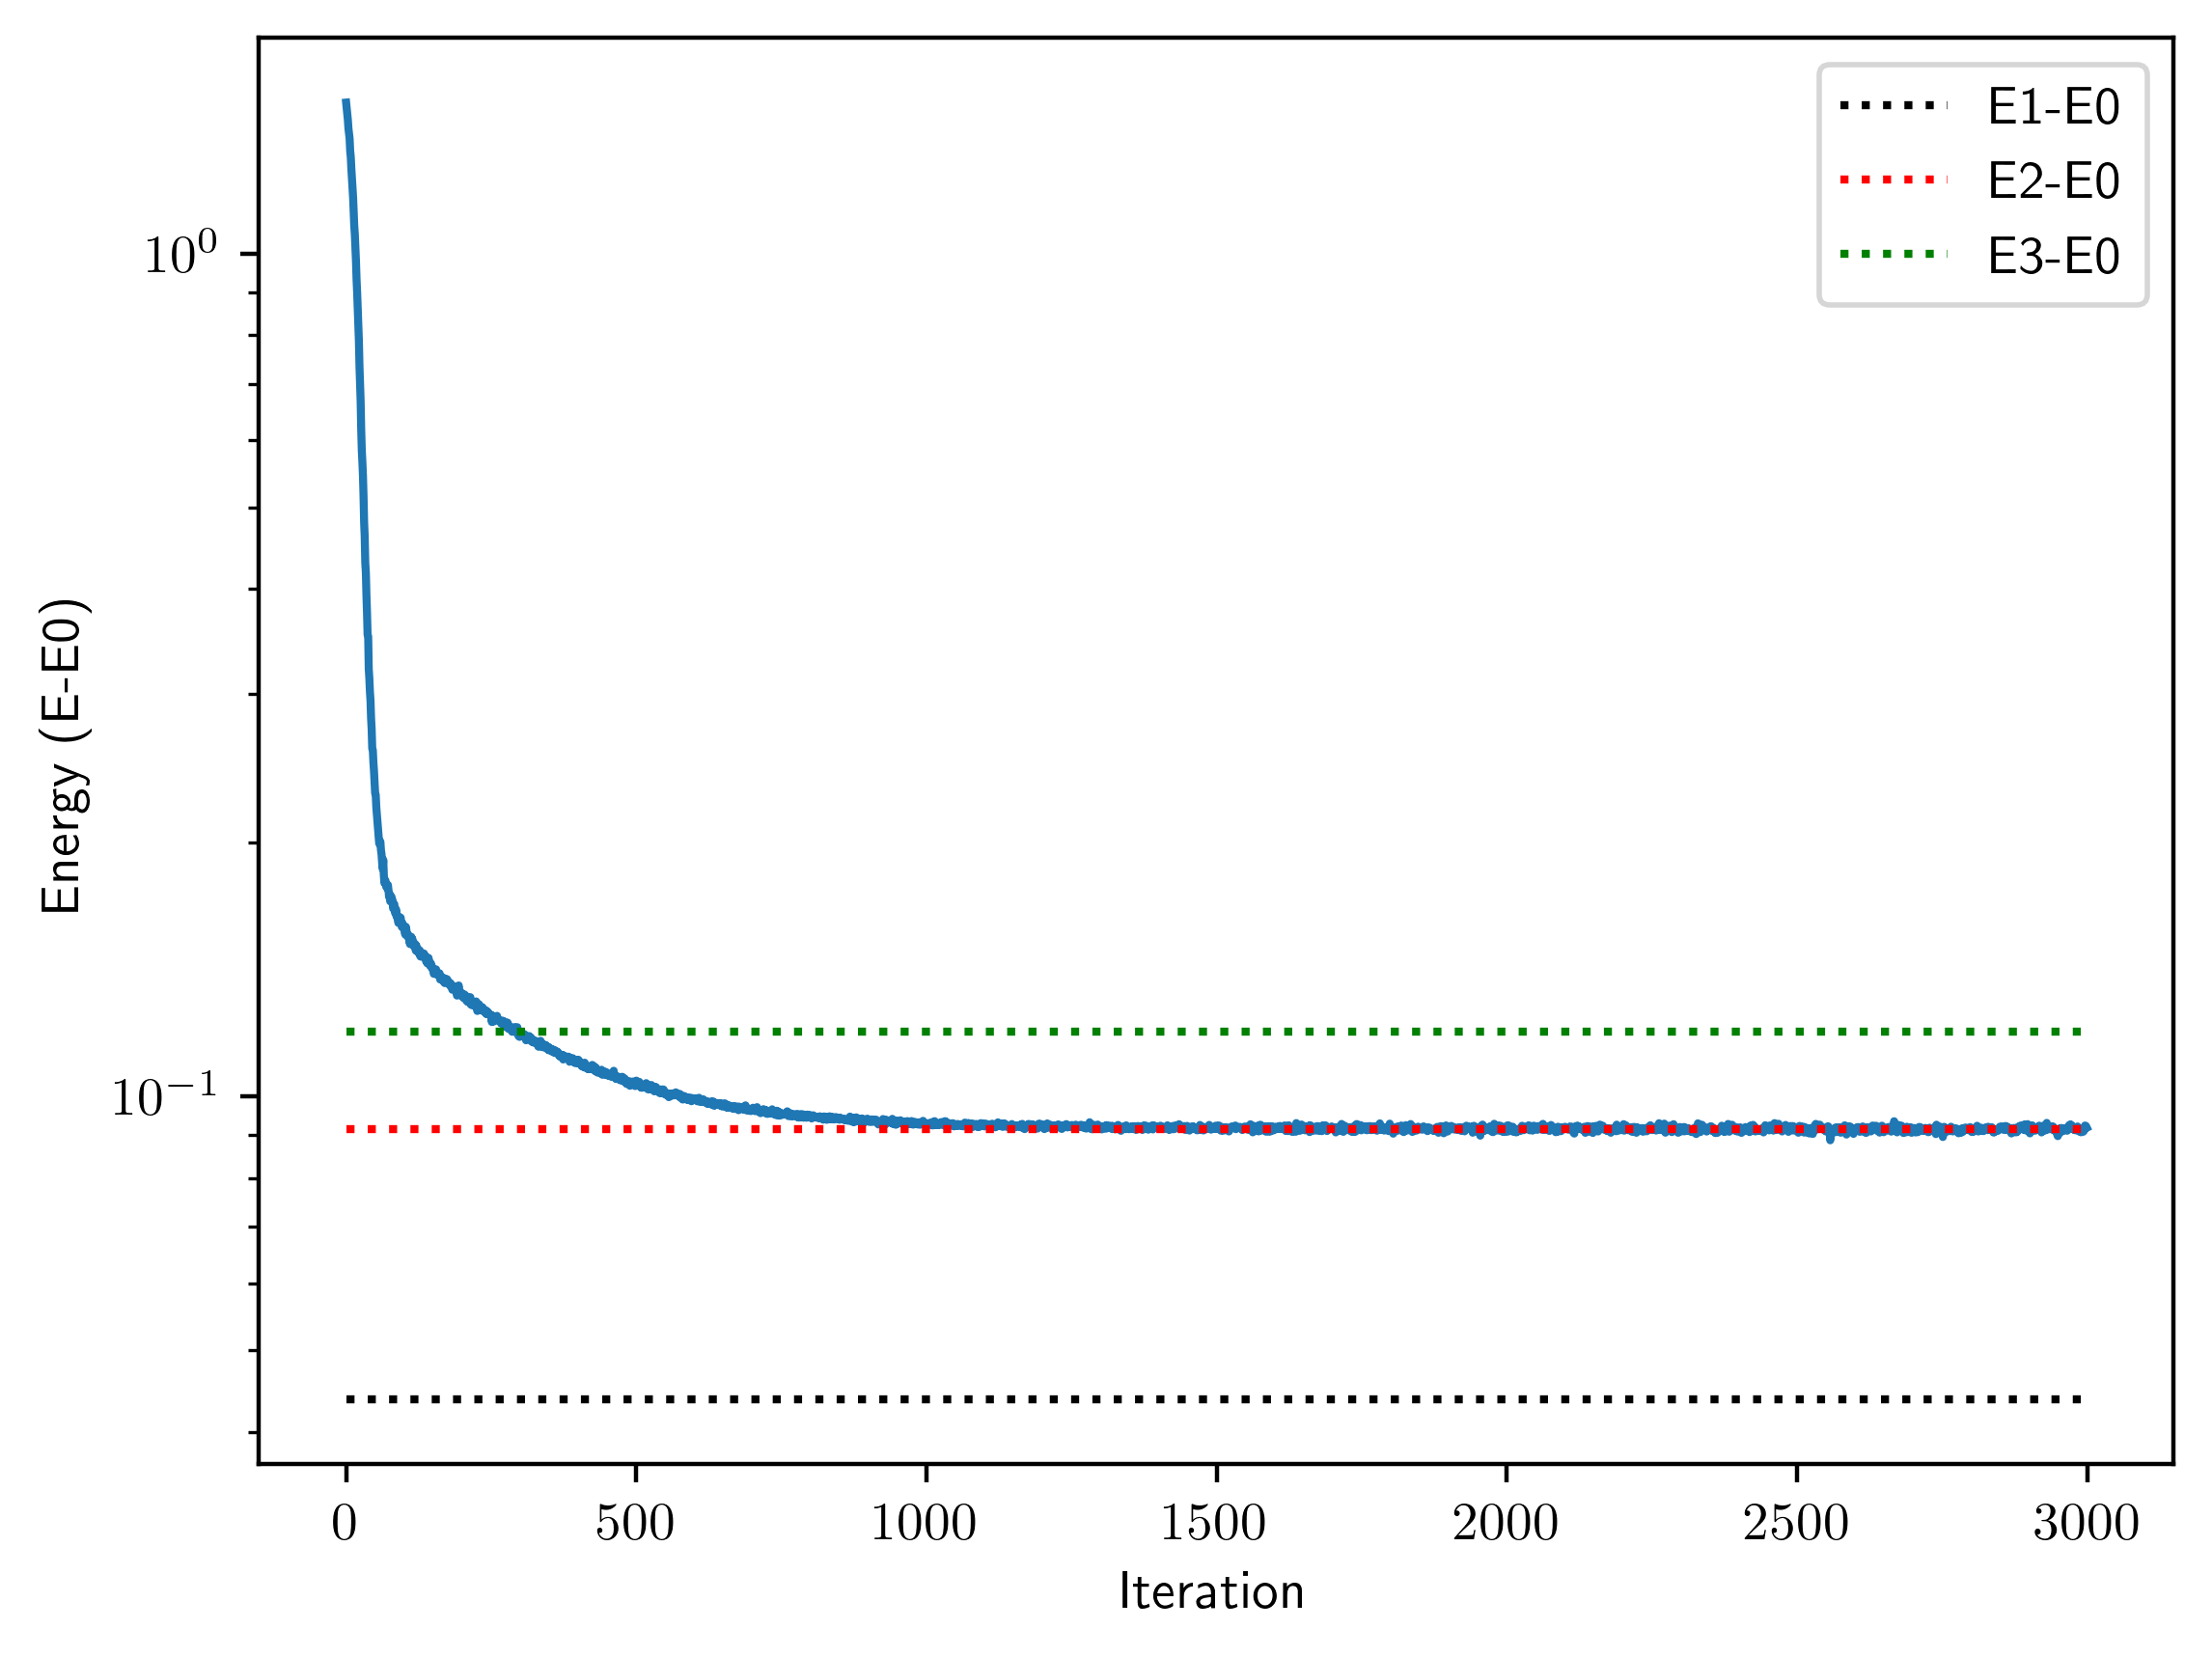

In [38]:
# let's now plot the energy descent plot
data = []
Eng = []
Iter = []
with open('Data/Logs6.log', 'r') as f:
#with open('2022_summer_analysis/Post_selected/excited_Logs_N6_i0_j32_best.log', 'r') as f:
    for line in f:
        data.append(line)
#use string tricks to convert everything to numbers
data = data[0].replace('[','!').replace(']','!').split('!')
Iter = list(map(int, data[1].split(',')))
Eng = list(map(float, data[3].split(',')))


import matplotlib
matplotlib.rcParams["figure.dpi"] = 400
plt.rcParams['text.usetex'] = True

e0 = e[0]

plt.plot(Iter, Eng-e0)

plt.hlines(e[1]-e0, 0, Iter[-1], color='black', linestyles='dotted', label = 'E1-E0')
plt.hlines(e[2]-e0, 0, Iter[-1], color='red', linestyles='dotted', label = 'E2-E0')
plt.hlines(e[3]-e0, 0, Iter[-1], color='green', linestyles='dotted', label = 'E3-E0')

plt.yscale('log')
plt.legend()
plt.ylabel('Energy (E-E0)')
plt.xlabel('Iteration')